In [1]:
# <examples/doc_model_two_components.py>
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText, fixed, Text
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]
import inspect

In [2]:
# def get_Latex_Func(func):
#     # Get the source code of the function
#     source_lines = inspect.getsource(func).split('\n')

#     # Find the return statement
#     return_line = [line for line in source_lines if 'return' in line][0]

#     # Extract the expression after 'return'
#     expr = return_line.split('return')[1].strip()
    
#     tatex_func = sympy.latex(sympy.sympify(expr))
#     strg = (
#         "\\begin{align} \n \t f(x) = " + tatex_func + "\n" + "\end{align} \n"
#     )
#     return strg


def get_Latex_Func(func):
    # Get the source code of the function
    source_lines = inspect.getsource(func).split('\n')
    
    # Find the return statement
    return_line = [line for line in source_lines if 'return' in line][0].strip()
    
    # Extract the expression after 'return'
    expr = return_line.split('return')[1].strip()
    
    # Extract variable names from the function's signature
    
    sig = inspect.signature(func)
    param_names = list(sig.parameters.keys())
    
    # Create sympy symbols for all parameters
    symbols = sympy.symbols(' '.join(param_names))
    
    # Create a local dictionary of symbols
    local_dict = dict(zip(param_names, symbols))
    
    # Add numpy and math functions to the local dictionary
    local_dict.update({
        'sqrt': sympy.sqrt,
        'exp': sympy.exp,
        'pi': sympy.pi
    })
    
    # Convert the expression to a SymPy expression
    sympy_expr = sympy.parsing.sympy_parser.parse_expr(
        expr.replace('np.', '').replace('math.', ''), 
        local_dict=local_dict
    )
    
    # Convert to LaTeX
    tatex_func = sympy.latex(sympy_expr)
    
    strg = (
        "\\begin{align} \n \t f(" + ", ".join(param_names) + ") = " + tatex_func + "\n" + "\\end{align} \n"
    )
    return strg




def save_data_to_file(filename='data.pkl'):
    # Dictionary für Parameter-Werte erstellen
    data_dict = {"x":Daten.get_x(),"xerr":Daten.get_xerr(),"y":Daten.get_y(),"yerr":Daten.get_yerr(),"XName":Daten.get_XName(),"YName":Daten.get_YName()}
    # Konvertiere alle Numpy-Arrays im Dictionary in Listen
    # dict_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value 
    #                      for key, value in data_dict.items()}
    # __x = []
    # __y = []
    # __xerr = 0
    # __yerr = 0
    # __XName = "x"
    # __YName = "y"
    # __FileName = "dataset_1"

    # Parameter als JSON-Datei speichern
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Daten wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_data_from_file(filename='params.pkl'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    
    # # Konvertiere Listen zurück in Numpy-Arrays
    # data_dict= {key: np.array(value) if isinstance(value, list) else value
    #                     for key, value in dict_with_arrays.items()}

    # Geladene Werte in die Parameter setzen
    Daten.set_x(data_dict.get("x"))
    Daten.set_xerr(data_dict.get("xerr"))
    Daten.set_y(data_dict.get("y"))
    Daten.set_yerr(data_dict.get("yerr"))
    Daten.set_XName(data_dict.get("XName"))
    Daten.set_YName(data_dict.get("YName"))

    print(f"Daten wurden aus {filename} geladen.")

def finish(x,y,result, string, y_err, yLabel, xLabel, var_func_bool= False):
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \\\\ \n" 
    string_fig += get_Latex_Func(Daten.get_func()) if var_func_bool else ""
    string_fig += table_of_params(result)
    text_file.write(string_fig)
    text_file.close()

def table_of_params(result_of_fit):
    sig_num = 3
    string = "" + (
        "\\begin{table}[ht] \n"
        "\centering \n") +"\caption{" + str(Daten.get_FileName()) +", Fit Parameter Tabelle} \n"  + (
        "\label{tab:my-table}\n"
        "\\begin{tabular}{|l|c|}\n" 
        "\hline\n"
        "Parameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " \\pm "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\end{tabular} \n"
        "\end{table}"
    )
    return string


class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    __FileName = "dataset_1",
    __Version = ""
    __pars = None
    __func = None
    
    def set_func(self, x):
        self.__func = x
        return
    def get_func(self):
        return self.__func

    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName
    
    def get_FileName(self):
        return self.__FileName
    
    def set_FileName(self, x):
        self.__FileName = f"{x}"
        return
    def set_Version(self, x):
        self.__Version = f"{x}"
        return
    def get_Version(self):
        return self.__Version
    
    def get_pars(self):
        return self.__pars
    def set_pars(self,x):
        self.__pars = x
        return

def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:str="0", skip_upper:str="0", x_name:str="x", y_name:str="y", save_bool=False,Save:int=0,Load:int=0,switch_axes:bool=False,show_plot:bool=True):
    data = np.genfromtxt(Datei+".txt", skip_header = int(skip_upper), skip_footer = int(skip_lower))
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)

    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    Daten.set_FileName(Datei)

    if switch_axes:
        temp = [Daten.get_x(), Daten.get_xerr()]
        Daten.set_x(Daten.get_y())
        Daten.set_xerr(Daten.get_yerr())
        Daten.set_y(temp[0])
        Daten.set_yerr(temp[1])
        
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_data_to_file(f'{Daten.get_FileName()}_daten_{Save}.pkl')
    if Load != 0:
        # Aufruf der Funktion zum Laden
        load_data_from_file(f'{Daten.get_FileName()}_daten_{Load}.pkl')

    if show_plot:
        plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
        plt.legend(loc='best')
        plt.ylabel(Daten.get_YName(), fontsize=20)
        plt.xlabel(Daten.get_XName(), fontsize=20)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        if save_bool:
            plt.savefig(Datei + f"_{Load}_Plot.pdf")
            string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Datei + "_Plot.pdf} \n" \
                + "\t\\caption{"+str(Datei)+", Plot_log} \n \t\\label{fig:"+str(Datei)+", Plot_log} \n\end{figure}"
            print(string_fig)

        plt.show()



# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

## Interactive

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# 'pip install pillow' but import PIL
from PIL import Image

png_filepath = "20250313_102047.jpg"
png_pil_img = np.array(Image.open(png_filepath).convert('L'))

png_pil_img.shape

(3024, 4032)

In [16]:
y = png_pil_img[1565,2555:]
x = np.arange(0, png_pil_img[1565,2555:].shape[0], 1)

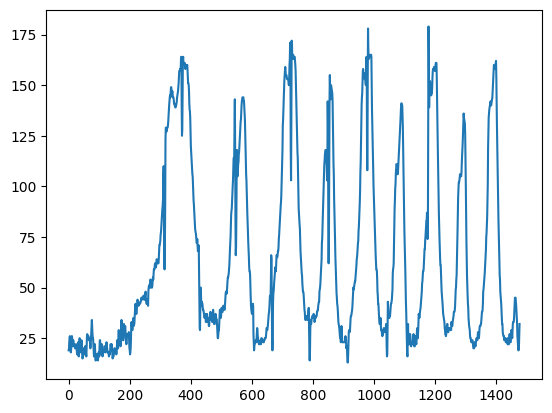

In [17]:
plt.plot(x,y)

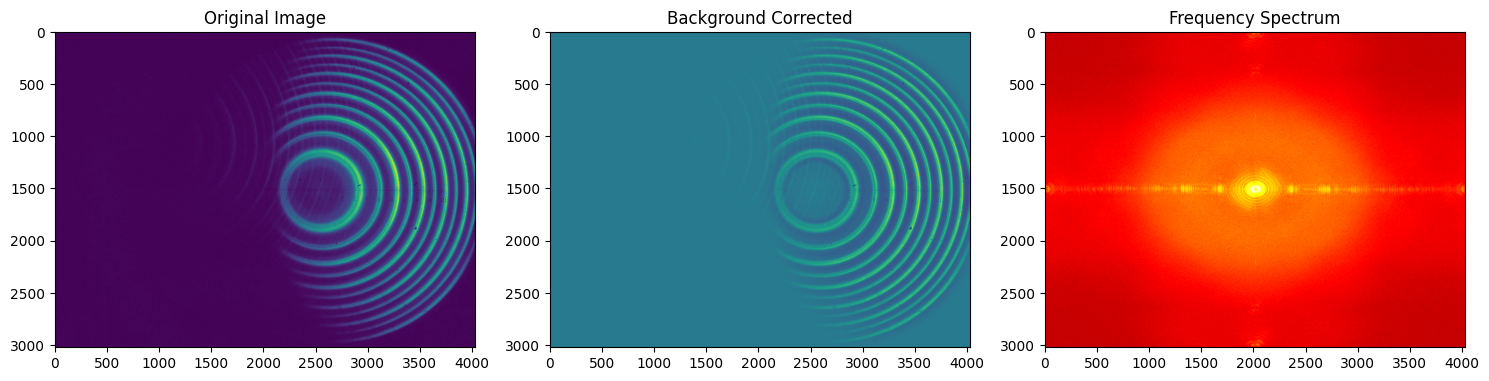

{'mean_intensity': 0.08752300109858753, 'max_intensity': 1.0, 'std_intensity': 0.14754071844121525}


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage import io, filters

def analyze_interferogram(image_path):
    # Read the image
    img = io.imread(image_path)
    
    # Convert to grayscale if color
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)
    
    # Normalize image
    img_normalized = (img - img.min()) / (img.max() - img.min())
    
    # Apply background correction
    background = filters.gaussian(img_normalized, sigma=50)
    img_corrected = img_normalized - background
    
    # Enhance contrast
    img_enhanced = filters.unsharp_mask(img_corrected, radius=2, amount=2)
    
    # Compute 2D Fourier Transform to analyze frequency components
    f_transform = np.fft.fft2(img_enhanced)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Compute power spectrum (log scale for better visualization)
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(img_normalized, cmap='viridis')
    
    plt.subplot(132)
    plt.title('Background Corrected')
    plt.imshow(img_corrected, cmap='viridis')
    
    plt.subplot(133)
    plt.title('Frequency Spectrum')
    plt.imshow(magnitude_spectrum, cmap='hot')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean_intensity': np.mean(img_normalized),
        'max_intensity': np.max(img_normalized),
        'std_intensity': np.std(img_normalized)
    }

# Example usage
results = analyze_interferogram(png_filepath)
print(results)

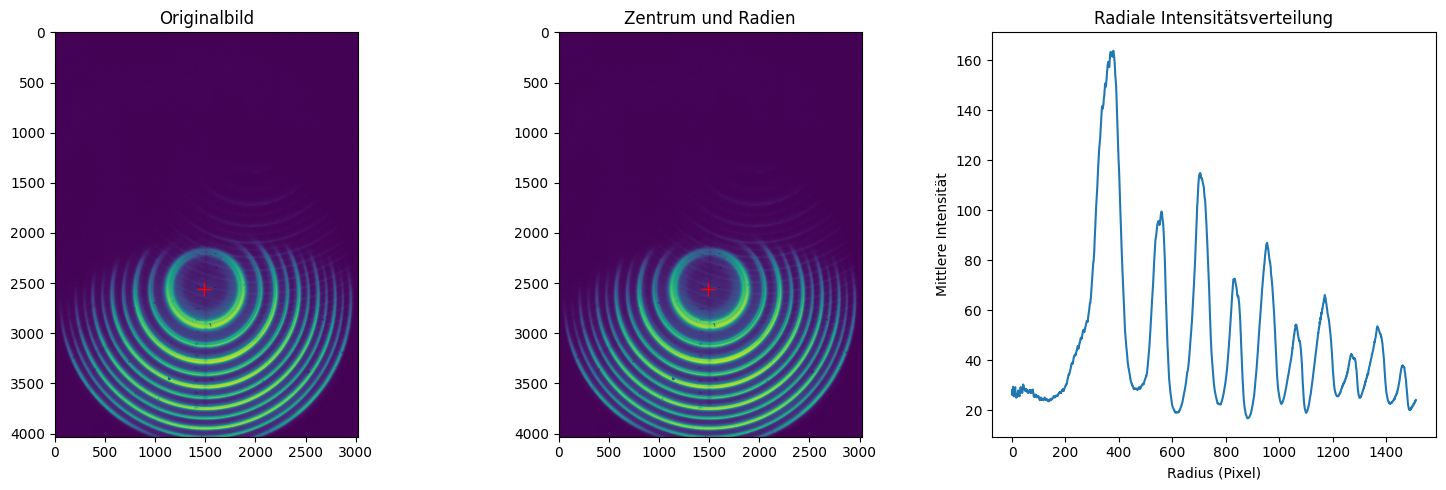

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def find_center(image, initial_guess=None):
    """
    Detect the center of the interference pattern with an optional initial guess
    
    Parameters:
    - image: Input grayscale image
    - initial_guess: Tuple (x, y) of initial center estimate
    
    Returns:
    - Refined center coordinates
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # If no initial guess, use image center
    if initial_guess is None:
        initial_guess = (gray.shape[1] // 2, gray.shape[0] // 2)
    
    # Define search region around initial guess
    search_radius = min(gray.shape) // 4
    
    # Extract search region
    y_start = max(0, initial_guess[1] - search_radius)
    y_end = min(gray.shape[0], initial_guess[1] + search_radius)
    x_start = max(0, initial_guess[0] - search_radius)
    x_end = min(gray.shape[1], initial_guess[0] + search_radius)
    
    region = gray[y_start:y_end, x_start:x_end]
    
    # Edge detection
    edges = cv2.Canny(region, 50, 150)
    
    # Hough Circle Detection
    circles = cv2.HoughCircles(
        edges, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20,
        param1=50, 
        param2=30, 
        minRadius=10, 
        maxRadius=min(region.shape)//2
    )
    
    # If circles found, use the most prominent one
    if circles is not None:
        circles = circles[0, :, :]
        best_circle = circles[0]
        
        # Adjust coordinates back to full image space
        center_x = x_start + int(best_circle[0])
        center_y = y_start + int(best_circle[1])
        
        return center_y, center_x
    
    # Fallback to initial guess
    return initial_guess[1], initial_guess[0]

def radial_intensity_profile(image_path, initial_center_guess=None):
    # Read image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Normalize image
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    
    # Find center with initial guess
    center_y, center_x = find_center(gray, initial_center_guess)
    
    # Create radial distance map
    y, x = np.indices(gray.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Bin radii and calculate mean intensities
    max_radius = min(gray.shape) // 2
    num_bins = 2000
    radii = np.linspace(0, max_radius, num_bins)
    intensities = []
    
    for i in range(len(radii)-1):
        mask = (r >= radii[i]) & (r < radii[i+1])
        if mask.sum() > 0:
            intensities.append(np.mean(gray[mask]))
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.title('Originalbild')
    plt.imshow(gray, cmap='viridis')
    plt.plot(center_x, center_y, 'r+', markersize=10)
    
    plt.subplot(132)
    plt.title('Zentrum und Radien')
    plt.imshow(gray, cmap='viridis')
    plt.plot(center_x, center_y, 'r+', markersize=10)
    
    plt.subplot(133)
    plt.title('Radiale Intensitätsverteilung')
    plt.plot(radii[:-1], intensities)
    plt.xlabel('Radius (Pixel)')
    plt.ylabel('Mittlere Intensität')
    
    plt.tight_layout()
    plt.show()
    
    return radii[:-1], intensities

# Beispielaufruf
# png_filepath = 'pfad_zu_deinem_interferogramm.png'

# Optional: Geben Sie eine Schätzung für das Zentrum an
# initial_center_guess = (x_koordinate, y_koordinate)

png_filepath = '20250313_102047.jpg'
initial_center_guess = (1370, 2370)  # Optional: Geben Sie eine initiale Schätzung an
radii, intensities = radial_intensity_profile(png_filepath, initial_center_guess)

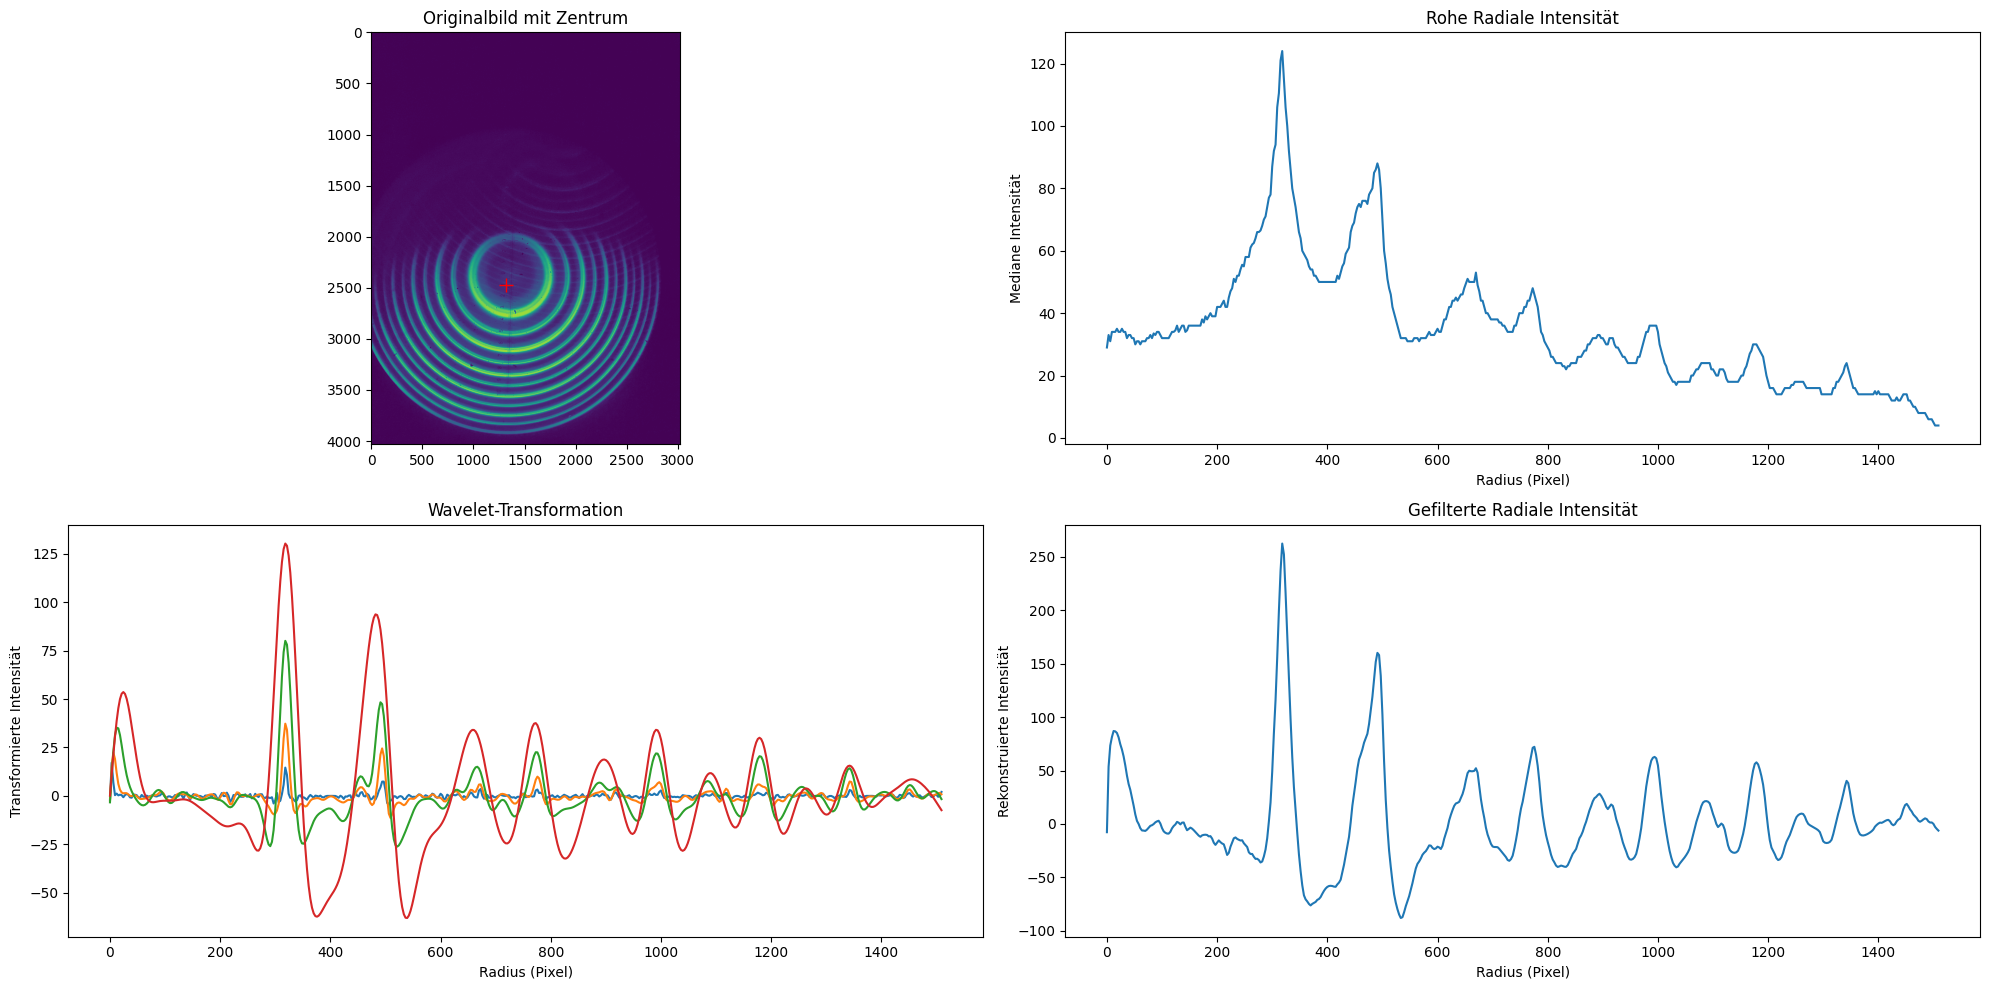

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 498 and the array at index 1 has size 499

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal

def find_center(image, initial_guess=None):
    """
    Detect the center of the interference pattern with an optional initial guess
    
    Parameters:
    - image: Input grayscale image
    - initial_guess: Tuple (x, y) of initial center estimate
    
    Returns:
    - Refined center coordinates
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # If no initial guess, use image center
    if initial_guess is None:
        initial_guess = (gray.shape[1] // 2, gray.shape[0] // 2)
    
    # Define search region around initial guess
    search_radius = min(gray.shape) // 4
    
    # Extract search region
    y_start = max(0, initial_guess[1] - search_radius)
    y_end = min(gray.shape[0], initial_guess[1] + search_radius)
    x_start = max(0, initial_guess[0] - search_radius)
    x_end = min(gray.shape[1], initial_guess[0] + search_radius)
    
    region = gray[y_start:y_end, x_start:x_end]
    
    # Edge detection
    edges = cv2.Canny(region, 50, 150)
    
    # Hough Circle Detection
    circles = cv2.HoughCircles(
        edges, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20,
        param1=50, 
        param2=30, 
        minRadius=10, 
        maxRadius=min(region.shape)//2
    )
    
    # If circles found, use the most prominent one
    if circles is not None:
        circles = circles[0, :, :]
        best_circle = circles[0]
        
        # Adjust coordinates back to full image space
        center_x = x_start + int(best_circle[0])
        center_y = y_start + int(best_circle[1])
        
        return center_y, center_x
    
    # Fallback to initial guess
    return initial_guess[1], initial_guess[0]

def enhanced_radial_intensity_profile(image_path, initial_center_guess=None, num_bins=500):
    # Bild laden und vorverarbeiten
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Zentrum mit vorheriger robuster Methode finden
    if initial_center_guess is None:
        initial_center_guess = (image.shape[1] // 2, image.shape[0] // 2)
    center_y, center_x = find_center(image, initial_center_guess)
    
    # Normalisierung mit verbesserter Kontrastanpassung
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Zusätzliche Bildverbesserung
    # Unscharf-Maskierung zur Verstärkung von Feinstrukturen
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    
    # Radiale Distanzmatrix erstellen
    y, x = np.indices(image.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Maximaler Radius und Binning
    max_radius = min(image.shape) // 2
    radii = np.linspace(0, max_radius, num_bins)
    intensities = []
    
    # Detailliertere Intensitätsberechnung
    for i in range(len(radii)-1):
        mask = (r >= radii[i]) & (r < radii[i+1])
        if mask.sum() > 0:
            # Verwende Median statt Mittelwert für robustere Ergebnisse
            intensities.append(np.median(image[mask]))
    
    # Zusätzliche Signalverarbeitung zur Hervorhebung der Feinstruktur
    # Wavelet-basierte Signaldekomposition
    intensities_array = np.array(intensities)
    
    # Wavelet-Transformation (Approximation)
    coeffs = signal.cwt(intensities_array, signal.ricker, [1, 2, 4, 8])
    
    # Visualisierung
    plt.figure(figsize=(20, 10))
    
    plt.subplot(221)
    plt.title('Originalbild mit Zentrum')
    plt.imshow(image, cmap='viridis')
    plt.plot(center_x, center_y, 'r+', markersize=10)
    
    plt.subplot(222)
    plt.title('Rohe Radiale Intensität')
    plt.plot(radii[:-1], intensities_array)
    plt.xlabel('Radius (Pixel)')
    plt.ylabel('Mediane Intensität')
    
    plt.subplot(223)
    plt.title('Wavelet-Transformation')
    for coeff in coeffs:
        plt.plot(radii[:-1], coeff)
    plt.xlabel('Radius (Pixel)')
    plt.ylabel('Transformierte Intensität')
    
    plt.subplot(224)
    plt.title('Gefilterte Radiale Intensität')
    # Rekonstruktion mit Wavelet-Koeffizienten
    filtered_intensities = np.sum(coeffs, axis=0)
    plt.plot(radii[:-1], filtered_intensities)
    plt.xlabel('Radius (Pixel)')
    plt.ylabel('Rekonstruierte Intensität')
    
    plt.tight_layout()
    plt.show()
    
    return radii[:-1], intensities_array, filtered_intensities

# Beispielaufruf
png_filepath = '20250313_102001.jpg'
initial_center_guess = (1370, 2370)  # Optional: Geben Sie eine initiale Schätzung an

radii, raw_intensities, filtered_intensities = enhanced_radial_intensity_profile(
    png_filepath, 
    initial_center_guess
)

# Optional: Speichern der Daten
np.savetxt('radial_intensities_detailed.csv', 
           np.column_stack((radii[:-1], raw_intensities, filtered_intensities)), 
           delimiter=',', 
           header='Radius,RawIntensity,FilteredIntensity')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# 'pip install pillow' but import PIL
from PIL import Image

png_filepath = "20250313_102047.jpg"
png_pil_img = Image.open(png_filepath)



In [10]:
Daten = Data()

interact(import_Data, Datei="messung1_Ring1", x_err_bool = False, y_err_bool = False, x_name = "Ordnung [au]", y_name = "Radius [au]", Daten=fixed(Daten), 
         skip_lower = "0",
         skip_upper = "1",
         save_bool = False,
         switch_axes = False,
         Save=IntText(value=0,description='Daten Speichern:'), Load=IntText(value=0,description='Daten Laden:'),
         
         )# IntText(value=0, step=1)
print()

interactive(children=(Text(value='messung1_Ring1', description='Datei'), Checkbox(value=False, description='x_…

## Fit-Funktionen festlegen

In [5]:
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel, Model, VoigtModel, LinearModel

# import pylandau

# def plot_func(x, mpv=1, eta=1, sigma=1, A=1):
#     return pylandau.langau(x, mpv, eta, sigma, A)

def plot_func(x, sigma = 1, nu = 1, amplitude=1):
    return amplitude/(sigma*np.sqrt(2*math.pi))*np.exp(-1/2*((x-nu)/sigma)**2)

Daten.set_func(plot_func)
mod = LinearModel()

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
slope,1.00000000,None,-inf,inf,True
intercept,0.00000000,None,-inf,inf,True


## Parameter Festlegen

In [6]:
# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

In [7]:
param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = IntText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, Save=IntText(value=0), Load=IntText(value=0), **param_widgets)
print()

interactive(children=(IntText(value=0, description='Save'), IntText(value=0, description='Load'), IntText(valu…

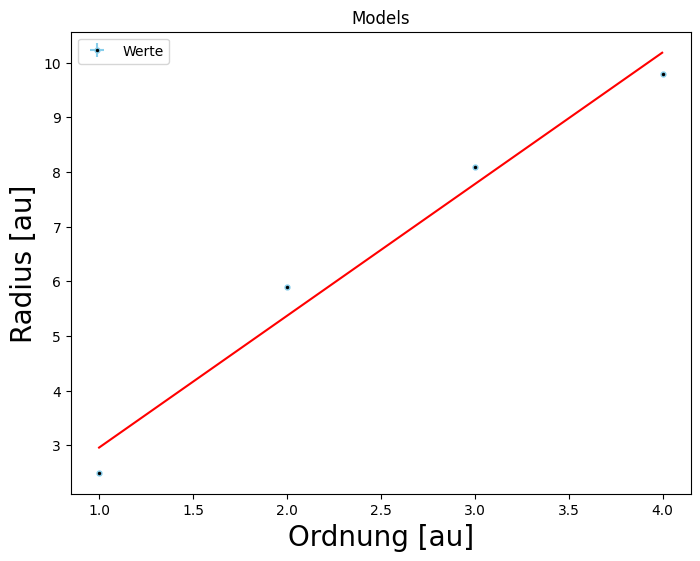

In [11]:
result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))

plt.figure(figsize=(8, 6))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')
plt.legend()
plt.ylabel(Daten.get_YName(), fontsize=20)
plt.xlabel(Daten.get_XName(), fontsize=20)
plt.title('Models')

plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))

plt.show()

In [9]:
Daten.get_pars()

In [17]:
Daten.get_yerr()

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 2. , 2. , 3. ,
       4. , 4. , 4. , 4. , 4. , 3. , 2. , 2. , 1. , 1. , 1. , 1. ])

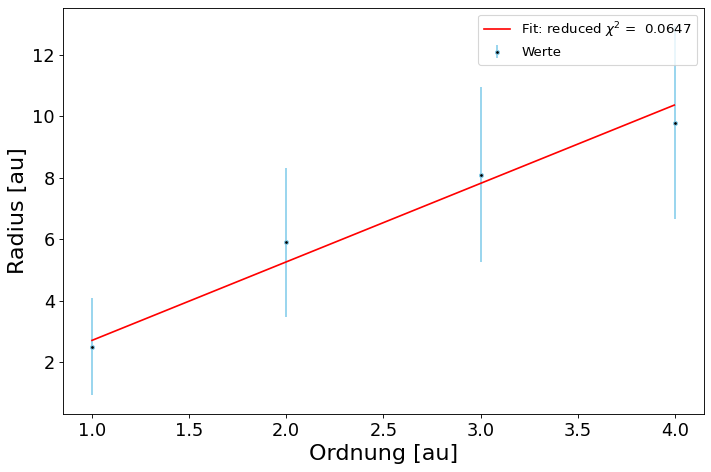

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/messung1_Ring1_Fit.pdf} 
	\caption{messung1_Ring1, Fit} 
 	\label{fig:messung1_Ring1, Fit} 
\end{figure}


In [12]:
weights = 1/np.sqrt(Daten.get_y())
weights[weights == np.inf] = 0
Daten.set_yerr(np.sqrt(Daten.get_y()))

result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), weights = weights)
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())

In [13]:
result

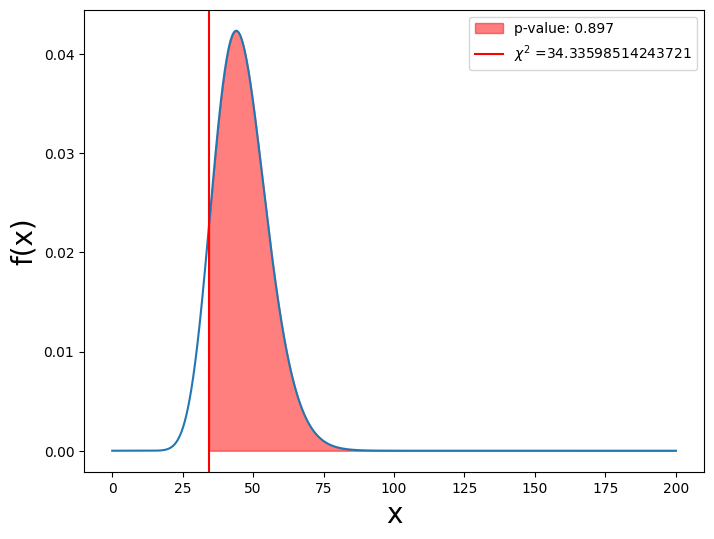

(0.897280458042388, 4.5680975355201955e-10)

In [41]:
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

def integrand(x, deg):
    return chi2(deg).pdf(x)

chi2_fit = result.chisqr
red_chi2 = result.redchi
deg = chi2_fit/red_chi2
p_val = quad(integrand, chi2_fit , np.inf, args = (deg))

x = np.arange(0,200, 0.01)

plt.figure(figsize=(8, 6))
plt.ylabel(r"f(x)", fontsize=20)
plt.xlabel("x", fontsize=20)
plt.plot(x, integrand(x, deg))
# Fill Integral area:
section = np.arange(chi2_fit, np.max(x), 0.01)
plt.fill_between(section, integrand(section, deg), color = "r", alpha = 0.5, label = f"p-value: {p_val[0]:.3}")
plt.axvline(chi2_fit, color = "r", label=r"$\chi^2$ =" +  f"{chi2_fit}")
plt.legend()
plt.savefig(f"{Daten.get_FileName()}_Pval{p_val[0]:.3}_chi2{chi2_fit}.pdf")
plt.show()
p_val

# Convolution

In [42]:
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from sympy import Symbol
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols, lambdify
x_val, x_= symbols("x_val, x_")
import scipy


In [43]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,142.336357,2.92632506,(2.06%),1000,-inf,inf,True,
center,2.94344771,0.00191267,(0.06%),3,-inf,inf,True,
sigma,0.05416051,0.00133543,(2.47%),1,0.00000000,inf,True,
slope,6.54018457,0.95473602,(14.60%),1,-inf,inf,True,
intercept,-2.12863286,1.55651566,(73.12%),0,-inf,inf,True,
gamma,0.05416051,0.00133543,(2.47%),1,-inf,inf,False,sigma
fwhm,0.19504774,0.00480928,(2.47%),3.6012906381881353,-inf,inf,False,1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)
height,548.497766,14.2000529,(2.59%),208.7092805203677,-inf,inf,False,"(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))))"


In [44]:
result.params["amplitude"].value
result.params["sigma"].value
result.params["center"].value
result.params["gamma"].value
 
def h(x):
    z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
    return (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)

In [45]:
result.params["amplitude"].value,result.params["sigma"].value,result.params["center"].value,result.params["gamma"].value


(142.3363574064359,
 0.054160510030471176,
 2.943447713559997,
 0.054160510030471176)

In [46]:
amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176

In [47]:
def integrand(a, b):
    return a*(b**3) *scipy.exp(-1/b)

# chi2_fit = result.chisqr
# red_chi2 = result.redchi
# deg = chi2_fit/red_chi2
integral =lambda b:quad(integrand, -1, scipy.inf, args = (b))
integral(20)

C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\1304330177.py:2: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*(b**3) *scipy.exp(-1/b)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\1304330177.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral =lambda b:quad(integrand, -1, scipy.inf, args = (b))


(11414.753082155767, 0.03132960094262671)

In [48]:
np.real(1+result.params["gamma"].value * 1j)

1.0

C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\4285284313.py:8: RuntimeWarning: invalid value encountered in multiply
  return (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)


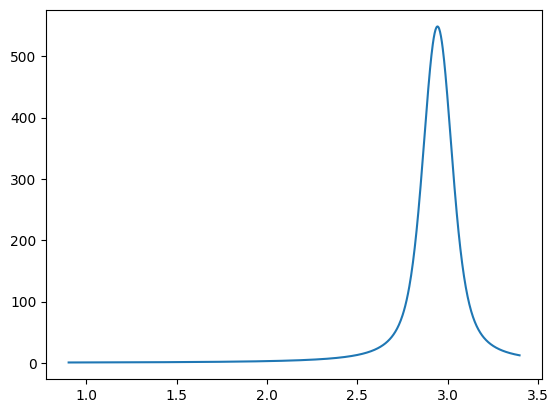

In [49]:
plt.plot(dynamic_resolution_array,h(dynamic_resolution_array))

In [50]:
def R(x:np.ndarray):
    z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
    y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
    # if y == np.inf:
    #     return 0
    # else:
    return y 

def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return

def h_pos(z,g):
    I = 0.5 # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170+273.15
    mu_b = 9.2740100783e-24
    cm_umrechnung = 2.54e-3
    z_0 = +1/2*mu_b*dB(I)*d1*(d2+d1/2)/k*T*g*cm_umrechnung
    a = z/z_0
    return 1/(a**3) *np.exp(-1/a)

def integrand(a, b, g):
    return R(b-a) * h_pos(a, g)

integral = lambda b, g:quad(integrand, -100, 100, args = (b, g))
integral(1, 2)

ZeroDivisionError: float division by zero

In [51]:
from scipy.integrate import quad
import numpy as np

# Beispielhafte Definition von R und h_pos (falls nicht definiert)
def R(x:np.ndarray):
    z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
    y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
    # if y == np.inf:
    #     return 0
    # else:
    return y 

def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return

def h_pos(z,g):
    I = 0.5 # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170+273.15
    mu_b = 9.2740100783e-24
    cm_umrechnung = 2.54e-3
    z_0 = +1/2*mu_b*dB(I)*d1*(d2+d1/2)/k*T*g*cm_umrechnung
    a = z/z_0
    return 1/(a**3) *np.exp(-1/a)

# Integrand mit Korrektur
def integrand(a, b, g):
    return R(b - a) * h_pos(a, g)

# Lambda-Funktion für das Integral
integral = lambda b, g: quad(integrand, 0, 10, args=(b, g))

# Beispielaufruf
b_ = 1
g_ = 0.5
result_, error = integral(b_, g_)

print("Ergebnis:", result)
print("Fehlerabschätzung:", error)


Ergebnis: <lmfit.model.ModelResult object at 0x0000017A95D02F90>
Fehlerabschätzung: nan


C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\3491283100.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\3491283100.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = lambda b, g: quad(integrand, 0, 10, args=(b, g))


In [ ]:
import numpy as np
import scipy.special

def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x: np.ndarray):
    try:
        z = (x - result.params["center"].value + result.params["gamma"].value * 1j) / (np.sqrt(2) * result.params["sigma"].value)
        y = (result.params["amplitude"].value * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * result.params["sigma"].value)
        
        # Fehlerbehandlung: Wenn der Wert zu groß oder NaN ist, setze ihn auf 0
        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            return np.zeros_like(y)
        return y
    except Exception as e:
        print(f"Fehler in R(x): {e}")
        return np.zeros_like(x)  # Rückgabe von 0 bei Fehlern

# Beispiel für die h_pos(z, g) mit Fehlerbehandlung
def h_pos(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = +1 / 2 * mu_b * dB(I) * d1 * (d2 + d1 / 2) / (k * T) * g #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
    
def h_neg(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = -1 / 2 * mu_b * dB(I) * d1 * (d2 + d1 / 2) / (k * T) * g #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
    
# Integrand mit Korrektur
def integrand(a, b, g):
    return R(b - a) * h_pos(a, g)

def integrand_neg(a, b, g):
    return R(b - a) * h_neg(a, g)

# Lambda-Funktion für das Integral
integral = lambda b, g: quad(integrand, -np.inf, 1000, args=(b, g))
integral_neg = lambda b, g: quad(integrand_neg, -1000, 1000, args=(b, g))
# Beispielaufruf
b_ = 1
g_ = 2
result_, error = integral(b_, g_)

print("Ergebnis:", result_)
print("Fehlerabschätzung:", error)


Fehler in h_pos(z, g): float division by zero
Ergebnis: 0.0
Fehlerabschätzung: 0.0


C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\104774830.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  y = (result.params["amplitude"].value * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * result.params["sigma"].value)


In [63]:
y_vals = []
y_vals_neg = []
for value in dynamic_resolution_array:
    y_vals.append(integral(value, 2))
    y_vals_neg.append(integral_neg(value, 2))

    

C:\Users\tlock\AppData\Local\Temp\ipykernel_12872\104774830.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  y = (result.params["amplitude"].value * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * result.params["sigma"].value)


Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float division by zero
Fehler in h_pos(z, g): float divis

In [64]:
np.array(y_vals)[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

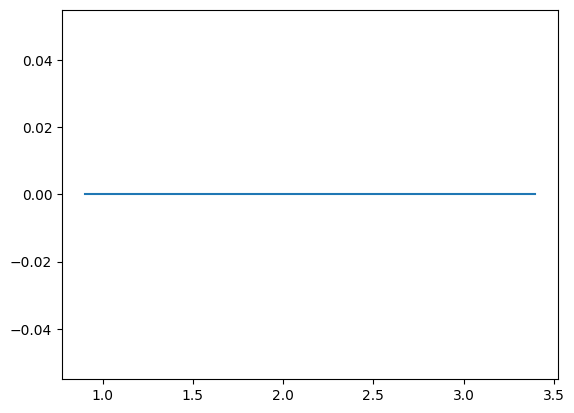

In [65]:
plt.plot(dynamic_resolution_array, np.array(y_vals)[:,0])


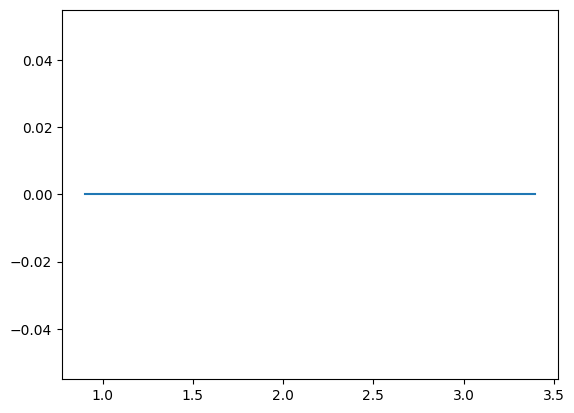

In [66]:
plt.plot(dynamic_resolution_array, np.array(y_vals_neg)[:,0])

C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\2227131761.py:3: RuntimeWarning: invalid value encountered in multiply
  y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)


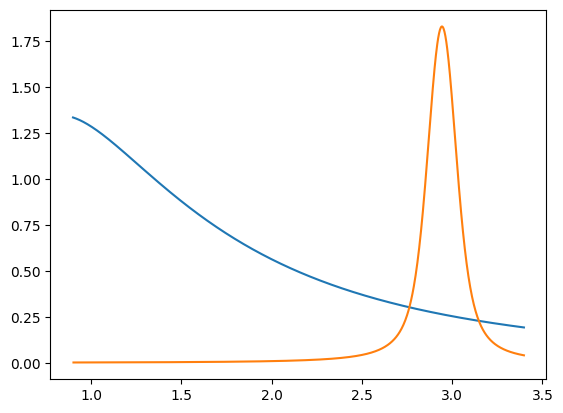

In [106]:
plt.plot(dynamic_resolution_array, h_pos(dynamic_resolution_array, 2))
plt.plot(dynamic_resolution_array, R(dynamic_resolution_array)*1/300)

In [83]:
b = 3.3
g = 2
quad(integrand, -np.inf, np.inf, args = (b, g))

C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\3749915835.py:26: RuntimeWarning: overflow encountered in exp
  return 1/(a**3) *np.exp(-1/a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\3749915835.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\3675667626.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(integrand, -np.inf, np.inf, args = (b, g))


(nan, nan)

In [ ]:
y = R(dynamic_resolution_array)
y[y == np.inf] = 0
y

2.209842097730547

In [69]:
def R(x:np.ndarray):
    z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
    y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
    if y == np.inf:
        return 0
    else:
        return y 
def h(x):
    x_0 = 0 #hier weiter
    a = x/x_0
    return 1/(a**3) *np.exp(-1/a)

def integrand(a, b):
    return R(b-a)

integral = lambda b:quad(integrand, 0, 5, args = (b))
for i in np.arange(0, 5, 0.1):
    print(integral(i))

C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\2610142190.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
C:\Users\tlock\AppData\Local\Temp\ipykernel_21804\2610142190.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = lambda b:quad(integrand, 0, 5, args = (b))


(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)


In [32]:
b = symbols("b")

plt.plot(dynamic_resolution_array, integral(lambdify(b, dynamic_resolution_array)))

NotImplementedError: unhandled type: <class 'numpy.ndarray'>, [0.9    0.9025 0.905  0.9075 0.91   0.9125 0.915  0.9175 0.92   0.9225
 0.925  0.9275 0.93   0.9325 0.935  0.9375 0.94   0.9425 0.945  0.9475
 0.95   0.9525 0.955  0.9575 0.96   0.9625 0.965  0.9675 0.97   0.9725
 0.975  0.9775 0.98   0.9825 0.985  0.9875 0.99   0.9925 0.995  0.9975
 1.     1.0025 1.005  1.0075 1.01   1.0125 1.015  1.0175 1.02   1.0225
 1.025  1.0275 1.03   1.0325 1.035  1.0375 1.04   1.0425 1.045  1.0475
 1.05   1.0525 1.055  1.0575 1.06   1.0625 1.065  1.0675 1.07   1.0725
 1.075  1.0775 1.08   1.0825 1.085  1.0875 1.09   1.0925 1.095  1.0975
 1.1    1.1025 1.105  1.1075 1.11   1.1125 1.115  1.1175 1.12   1.1225
 1.125  1.1275 1.13   1.1325 1.135  1.1375 1.14   1.1425 1.145  1.1475
 1.15   1.1525 1.155  1.1575 1.16   1.1625 1.165  1.1675 1.17   1.1725
 1.175  1.1775 1.18   1.1825 1.185  1.1875 1.19   1.1925 1.195  1.1975
 1.2    1.2025 1.205  1.2075 1.21   1.2125 1.215  1.2175 1.22   1.2225
 1.225  1.2275 1.23   1.2325 1.235  1.2375 1.24   1.2425 1.245  1.2475
 1.25   1.2525 1.255  1.2575 1.26   1.2625 1.265  1.2675 1.27   1.2725
 1.275  1.2775 1.28   1.2825 1.285  1.2875 1.29   1.2925 1.295  1.2975
 1.3    1.3025 1.305  1.3075 1.31   1.3125 1.315  1.3175 1.32   1.3225
 1.325  1.3275 1.33   1.3325 1.335  1.3375 1.34   1.3425 1.345  1.3475
 1.35   1.3525 1.355  1.3575 1.36   1.3625 1.365  1.3675 1.37   1.3725
 1.375  1.3775 1.38   1.3825 1.385  1.3875 1.39   1.3925 1.395  1.3975
 1.4    1.4025 1.405  1.4075 1.41   1.4125 1.415  1.4175 1.42   1.4225
 1.425  1.4275 1.43   1.4325 1.435  1.4375 1.44   1.4425 1.445  1.4475
 1.45   1.4525 1.455  1.4575 1.46   1.4625 1.465  1.4675 1.47   1.4725
 1.475  1.4775 1.48   1.4825 1.485  1.4875 1.49   1.4925 1.495  1.4975
 1.5    1.5025 1.505  1.5075 1.51   1.5125 1.515  1.5175 1.52   1.5225
 1.525  1.5275 1.53   1.5325 1.535  1.5375 1.54   1.5425 1.545  1.5475
 1.55   1.5525 1.555  1.5575 1.56   1.5625 1.565  1.5675 1.57   1.5725
 1.575  1.5775 1.58   1.5825 1.585  1.5875 1.59   1.5925 1.595  1.5975
 1.6    1.6025 1.605  1.6075 1.61   1.6125 1.615  1.6175 1.62   1.6225
 1.625  1.6275 1.63   1.6325 1.635  1.6375 1.64   1.6425 1.645  1.6475
 1.65   1.6525 1.655  1.6575 1.66   1.6625 1.665  1.6675 1.67   1.6725
 1.675  1.6775 1.68   1.6825 1.685  1.6875 1.69   1.6925 1.695  1.6975
 1.7    1.7025 1.705  1.7075 1.71   1.7125 1.715  1.7175 1.72   1.7225
 1.725  1.7275 1.73   1.7325 1.735  1.7375 1.74   1.7425 1.745  1.7475
 1.75   1.7525 1.755  1.7575 1.76   1.7625 1.765  1.7675 1.77   1.7725
 1.775  1.7775 1.78   1.7825 1.785  1.7875 1.79   1.7925 1.795  1.7975
 1.8    1.8025 1.805  1.8075 1.81   1.8125 1.815  1.8175 1.82   1.8225
 1.825  1.8275 1.83   1.8325 1.835  1.8375 1.84   1.8425 1.845  1.8475
 1.85   1.8525 1.855  1.8575 1.86   1.8625 1.865  1.8675 1.87   1.8725
 1.875  1.8775 1.88   1.8825 1.885  1.8875 1.89   1.8925 1.895  1.8975
 1.9    1.9025 1.905  1.9075 1.91   1.9125 1.915  1.9175 1.92   1.9225
 1.925  1.9275 1.93   1.9325 1.935  1.9375 1.94   1.9425 1.945  1.9475
 1.95   1.9525 1.955  1.9575 1.96   1.9625 1.965  1.9675 1.97   1.9725
 1.975  1.9775 1.98   1.9825 1.985  1.9875 1.99   1.9925 1.995  1.9975
 2.     2.0025 2.005  2.0075 2.01   2.0125 2.015  2.0175 2.02   2.0225
 2.025  2.0275 2.03   2.0325 2.035  2.0375 2.04   2.0425 2.045  2.0475
 2.05   2.0525 2.055  2.0575 2.06   2.0625 2.065  2.0675 2.07   2.0725
 2.075  2.0775 2.08   2.0825 2.085  2.0875 2.09   2.0925 2.095  2.0975
 2.1    2.1025 2.105  2.1075 2.11   2.1125 2.115  2.1175 2.12   2.1225
 2.125  2.1275 2.13   2.1325 2.135  2.1375 2.14   2.1425 2.145  2.1475
 2.15   2.1525 2.155  2.1575 2.16   2.1625 2.165  2.1675 2.17   2.1725
 2.175  2.1775 2.18   2.1825 2.185  2.1875 2.19   2.1925 2.195  2.1975
 2.2    2.2025 2.205  2.2075 2.21   2.2125 2.215  2.2175 2.22   2.2225
 2.225  2.2275 2.23   2.2325 2.235  2.2375 2.24   2.2425 2.245  2.2475
 2.25   2.2525 2.255  2.2575 2.26   2.2625 2.265  2.2675 2.27   2.2725
 2.275  2.2775 2.28   2.2825 2.285  2.2875 2.29   2.2925 2.295  2.2975
 2.3    2.3025 2.305  2.3075 2.31   2.3125 2.315  2.3175 2.32   2.3225
 2.325  2.3275 2.33   2.3325 2.335  2.3375 2.34   2.3425 2.345  2.3475
 2.35   2.3525 2.355  2.3575 2.36   2.3625 2.365  2.3675 2.37   2.3725
 2.375  2.3775 2.38   2.3825 2.385  2.3875 2.39   2.3925 2.395  2.3975
 2.4    2.4025 2.405  2.4075 2.41   2.4125 2.415  2.4175 2.42   2.4225
 2.425  2.4275 2.43   2.4325 2.435  2.4375 2.44   2.4425 2.445  2.4475
 2.45   2.4525 2.455  2.4575 2.46   2.4625 2.465  2.4675 2.47   2.4725
 2.475  2.4775 2.48   2.4825 2.485  2.4875 2.49   2.4925 2.495  2.4975
 2.5    2.5025 2.505  2.5075 2.51   2.5125 2.515  2.5175 2.52   2.5225
 2.525  2.5275 2.53   2.5325 2.535  2.5375 2.54   2.5425 2.545  2.5475
 2.55   2.5525 2.555  2.5575 2.56   2.5625 2.565  2.5675 2.57   2.5725
 2.575  2.5775 2.58   2.5825 2.585  2.5875 2.59   2.5925 2.595  2.5975
 2.6    2.6025 2.605  2.6075 2.61   2.6125 2.615  2.6175 2.62   2.6225
 2.625  2.6275 2.63   2.6325 2.635  2.6375 2.64   2.6425 2.645  2.6475
 2.65   2.6525 2.655  2.6575 2.66   2.6625 2.665  2.6675 2.67   2.6725
 2.675  2.6775 2.68   2.6825 2.685  2.6875 2.69   2.6925 2.695  2.6975
 2.7    2.7025 2.705  2.7075 2.71   2.7125 2.715  2.7175 2.72   2.7225
 2.725  2.7275 2.73   2.7325 2.735  2.7375 2.74   2.7425 2.745  2.7475
 2.75   2.7525 2.755  2.7575 2.76   2.7625 2.765  2.7675 2.77   2.7725
 2.775  2.7775 2.78   2.7825 2.785  2.7875 2.79   2.7925 2.795  2.7975
 2.8    2.8025 2.805  2.8075 2.81   2.8125 2.815  2.8175 2.82   2.8225
 2.825  2.8275 2.83   2.8325 2.835  2.8375 2.84   2.8425 2.845  2.8475
 2.85   2.8525 2.855  2.8575 2.86   2.8625 2.865  2.8675 2.87   2.8725
 2.875  2.8775 2.88   2.8825 2.885  2.8875 2.89   2.8925 2.895  2.8975
 2.9    2.9025 2.905  2.9075 2.91   2.9125 2.915  2.9175 2.92   2.9225
 2.925  2.9275 2.93   2.9325 2.935  2.9375 2.94   2.9425 2.945  2.9475
 2.95   2.9525 2.955  2.9575 2.96   2.9625 2.965  2.9675 2.97   2.9725
 2.975  2.9775 2.98   2.9825 2.985  2.9875 2.99   2.9925 2.995  2.9975
 3.     3.0025 3.005  3.0075 3.01   3.0125 3.015  3.0175 3.02   3.0225
 3.025  3.0275 3.03   3.0325 3.035  3.0375 3.04   3.0425 3.045  3.0475
 3.05   3.0525 3.055  3.0575 3.06   3.0625 3.065  3.0675 3.07   3.0725
 3.075  3.0775 3.08   3.0825 3.085  3.0875 3.09   3.0925 3.095  3.0975
 3.1    3.1025 3.105  3.1075 3.11   3.1125 3.115  3.1175 3.12   3.1225
 3.125  3.1275 3.13   3.1325 3.135  3.1375 3.14   3.1425 3.145  3.1475
 3.15   3.1525 3.155  3.1575 3.16   3.1625 3.165  3.1675 3.17   3.1725
 3.175  3.1775 3.18   3.1825 3.185  3.1875 3.19   3.1925 3.195  3.1975
 3.2    3.2025 3.205  3.2075 3.21   3.2125 3.215  3.2175 3.22   3.2225
 3.225  3.2275 3.23   3.2325 3.235  3.2375 3.24   3.2425 3.245  3.2475
 3.25   3.2525 3.255  3.2575 3.26   3.2625 3.265  3.2675 3.27   3.2725
 3.275  3.2775 3.28   3.2825 3.285  3.2875 3.29   3.2925 3.295  3.2975
 3.3    3.3025 3.305  3.3075 3.31   3.3125 3.315  3.3175 3.32   3.3225
 3.325  3.3275 3.33   3.3325 3.335  3.3375 3.34   3.3425 3.345  3.3475
 3.35   3.3525 3.355  3.3575 3.36   3.3625 3.365  3.3675 3.37   3.3725
 3.375  3.3775 3.38   3.3825 3.385  3.3875 3.39   3.3925 3.395  3.3975]

In [62]:
def integrand(x_, x_val):
    return result.eval(x_val-x_)*1/(x_val**3) *np.exp(-1/x_val)

# chi2_fit = result.chisqr
# red_chi2 = result.redchi
# deg = chi2_fit/red_chi2
quad(integrand, -scipy.inf , scipy.inf, args = (x_val))

TypeError: argument of type 'Add' is not iterable

In [ ]:


resulution_array = np.arange(0,200, 0.01)

plt.figure(figsize=(8, 6))
plt.ylabel(r"f(x)", fontsize=20)
plt.xlabel("x", fontsize=20)
plt.plot(x, integrand(x, deg))
# Fill Integral area:
section = np.arange(chi2_fit, np.max(resulution_array), 0.01)
plt.fill_between(section, integrand(section, deg), color = "r", alpha = 0.5, label = f"p-value: {p_val[0]:.3}")
plt.axvline(chi2_fit, color = "r", label=r"$\chi^2$ =" +  f"{chi2_fit}")
plt.legend()
plt.savefig(f"{Daten.get_FileName()}_Pval{p_val[0]:.3}_chi2{chi2_fit}.pdf")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'items'